## CSS Project Part 2
Arathy Pillai, Alexander Guth, Hammad Akthar, Hiba Saleel and Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from string import punctuation

In [2]:
plot_size = plt.rcParams["figure.figsize"]  
plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

### Load data and determine na values
repost and Text are determined as na values, because they ... **[TODO]**

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
#na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)
ira_data = ira_data[ira_data['AD_IMPRESSIONS']>0]

### Click per View Ratio
#Clicks / #Impressions

In [4]:
ira_data.insert(5, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

### Date operations
Get epoch time (ms since 01.01.1970)

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

In [6]:
ira_data['AD_CREATION_WEEKDAY'] = ira_data['AD_CREATION_DATE'].dt.dayofweek
ira_data['AD_CREATION_YEAR'] = ira_data['AD_CREATION_DATE'].dt.year
ira_data['AD_CREATION_MONTH'] = ira_data['AD_CREATION_DATE'].dt.month
ira_data['AD_CREATION_DAY'] = ira_data['AD_CREATION_DATE'].dt.day
ira_data['AD_CREATION_TIME'] = ira_data['AD_CREATION_DATE'].dt.time
ira_data['AD_CREATION_EPOCH_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: unix_time_millis(x))

### Convert ruble
Removes "RUB" from the cell AD_SPEND

In [7]:
ira_data['AD_SPEND']=ira_data['AD_SPEND'].str.replace(' RUB','')

### Drop all subsets, where AD_TEXT is na

In [8]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

2533

### Remove hyperlinks

In [9]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

### Select all duplicate ad texts

In [10]:
duplicateDF = pd.concat(g for _, g in ira_data.groupby("AD_TEXT") if len(g) > 1).copy()
duplicateDF.sort_values(by=['AD_TEXT'], inplace=True)

In [11]:
uniqueDF = ira_data.copy()
uniqueDF.drop_duplicates(subset ='AD_TEXT', 
                     keep = False, inplace = True)

### Total Duplicates

In [12]:
ira_data['AD_TEXT'].count()

2533

In [13]:
duplicateDF['AD_TEXT'].count()

614

In [14]:
uniqueDF['AD_TEXT'].count()

1919

### Unique Duplicate Pairs

In [15]:
duplicateDF['AD_TEXT'].nunique()

203

### Occurence of Duplicate Pairs

In [16]:
duplicateDF['AD_TEXT'].value_counts().values

array([13, 12,  9,  8,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [18]:
duplicateDF[(duplicateDF['AD_IMPRESSIONS']>0) & duplicateDF['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_DATE', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME','AD_TEXT', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].head(20)

,AD_CLICKS,AD_IMPRESSIONS,AD_CREATION_DATE,AD_CREATION_WEEKDAY,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME,AD_TEXT,AD_SPEND,AD_POTENTIAL_TARGET
AD_ID,,,,,,,,,,,
669,91,1997,2015-06-17 03:15:18,2,2015,6,17,03:15:18,We speak for all fellow members of LGBT commun...,2673.94,144000000.0
591,5441,93925,2016-03-23 05:36:11,2,2016,3,23,05:36:11,We speak for all fellow members of LGBT commun...,31713.12,NaN
590,6566,67221,2015-11-05 23:11:58,3,2015,11,5,23:11:58,We speak for all fellow members of LGBT commun...,46994.76,36000000.0
588,21449,175460,2015-07-14 00:01:38,1,2015,7,14,00:01:38,We speak for all fellow members of LGBT commun...,93754.38,41000000.0
587,542,15175,2015-07-09 01:50:28,3,2015,7,9,01:50:28,We speak for all fellow members of LGBT commun...,6201.70,35000000.0
586,59,1811,2015-07-07 01:51:07,1,2015,7,7,01:51:07,We speak for all fellow members of LGBT commun...,757.65,166000000.0
592,7289,190076,2016-08-04 04:20:05,3,2016,8,4,04:20:05,We speak for all fellow members of LGBT commun...,36000.00,NaN
584,3206,31618,2015-06-23 05:06:57,1,2015,6,23,05:06:57,We speak for all fellow members of LGBT commun...,16630.20,143000000.0
583,186,4265,2015-06-22 08:19:07,0,2015,6,22,08:19:07,We speak for all fellow members of LGBT commun...,1393.55,139000000.0


### Common Statistics
**TODO** Mean, median etc. for success --> Chart(?)

### Correlations
**TODO** Weekday Spearman Correlation

In [19]:
corrDf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']]
corrDf = corrDf.dropna()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET,AD_CREATION_WEEKDAY,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY
AD_CLICKS,1.000000,0.896796,0.078755,-0.011031,0.016672,0.091372,0.067714,0.015466,-0.013021
AD_IMPRESSIONS,0.896796,1.000000,-0.055164,-0.015568,0.012580,0.008584,-0.016980,0.053521,-0.039594
AD_CLICKS_PER_VIEW,0.078755,-0.055164,1.000000,-0.038493,0.069932,0.291151,0.255577,-0.046038,0.125583
AD_POTENTIAL_TARGET,-0.011031,-0.015568,-0.038493,1.000000,0.030125,-0.203603,-0.158422,-0.016134,-0.007085
AD_CREATION_WEEKDAY,0.016672,0.012580,0.069932,0.030125,1.000000,0.043388,0.064794,-0.064840,0.042066
AD_CREATION_EPOCH_TIME,0.091372,0.008584,0.291151,-0.203603,0.043388,1.000000,0.886523,-0.161289,0.198290
AD_CREATION_YEAR,0.067714,-0.016980,0.255577,-0.158422,0.064794,0.886523,1.000000,-0.598465,0.199706
AD_CREATION_MONTH,0.015466,0.053521,-0.046038,-0.016134,-0.064840,-0.161289,-0.598465,1.000000,-0.151057
AD_CREATION_DAY,-0.013021,-0.039594,0.125583,-0.007085,0.042066,0.198290,0.199706,-0.151057,1.000000


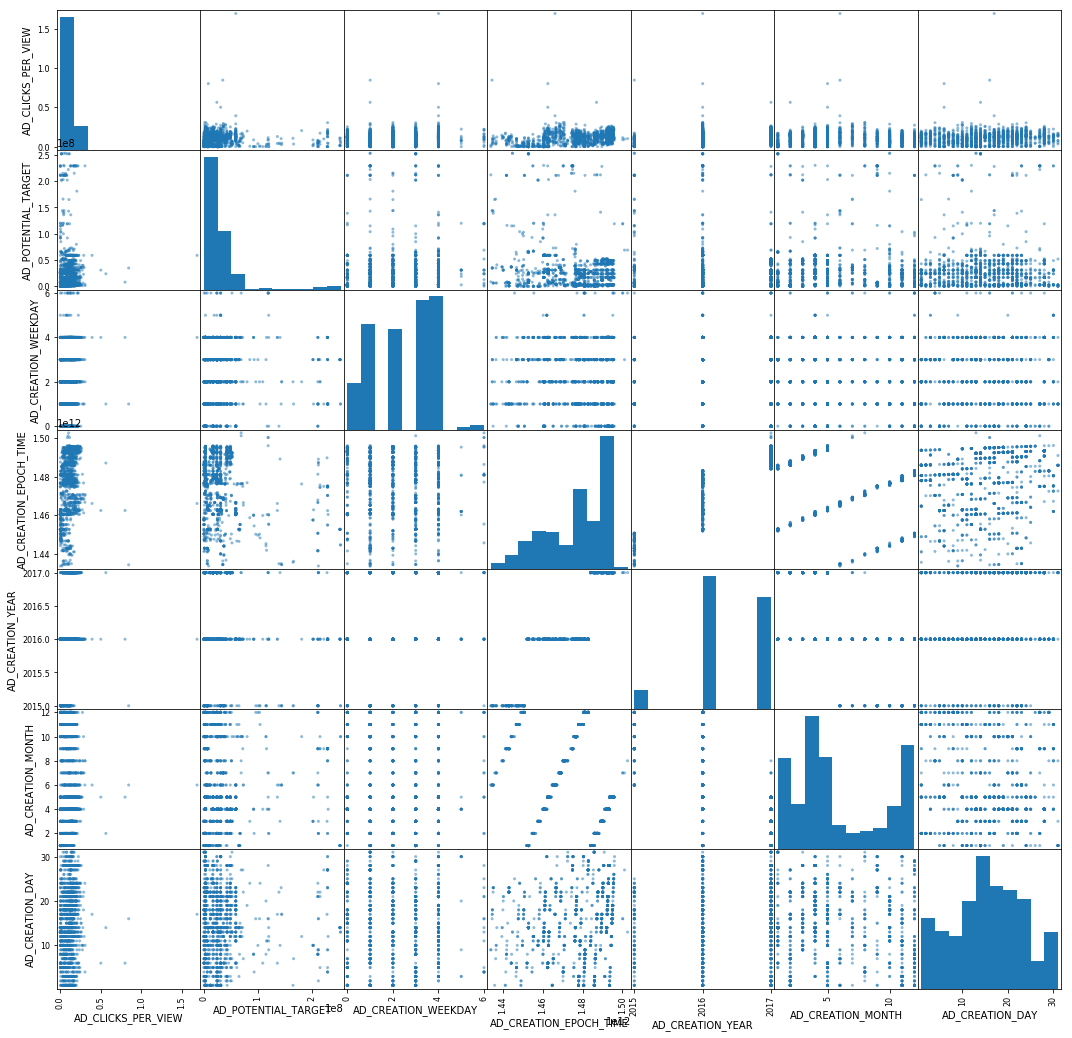

In [20]:
scatter_matrix(corrDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], figsize=(18, 18))
corrDf.corr()

In [21]:
corrUniqueDf = uniqueDF[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']]
corrUniqueDf = corrUniqueDf.dropna()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET,AD_CREATION_WEEKDAY,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY
AD_CLICKS,1.000000,0.885035,0.084390,0.057343,0.009053,0.191741,0.184810,-0.076687,-0.006334
AD_IMPRESSIONS,0.885035,1.000000,-0.063463,0.052728,-0.014025,0.057314,0.060529,-0.032809,-0.024363
AD_CLICKS_PER_VIEW,0.084390,-0.063463,1.000000,-0.014574,0.093513,0.238093,0.232929,-0.110349,0.106875
AD_POTENTIAL_TARGET,0.057343,0.052728,-0.014574,1.000000,0.058002,-0.238598,-0.177256,-0.012005,-0.066430
AD_CREATION_WEEKDAY,0.009053,-0.014025,0.093513,0.058002,1.000000,0.018346,0.028773,-0.036911,0.083272
AD_CREATION_EPOCH_TIME,0.191741,0.057314,0.238093,-0.238598,0.018346,1.000000,0.894732,-0.268369,0.225378
AD_CREATION_YEAR,0.184810,0.060529,0.232929,-0.177256,0.028773,0.894732,1.000000,-0.669062,0.231454
AD_CREATION_MONTH,-0.076687,-0.032809,-0.110349,-0.012005,-0.036911,-0.268369,-0.669062,1.000000,-0.196343
AD_CREATION_DAY,-0.006334,-0.024363,0.106875,-0.066430,0.083272,0.225378,0.231454,-0.196343,1.000000


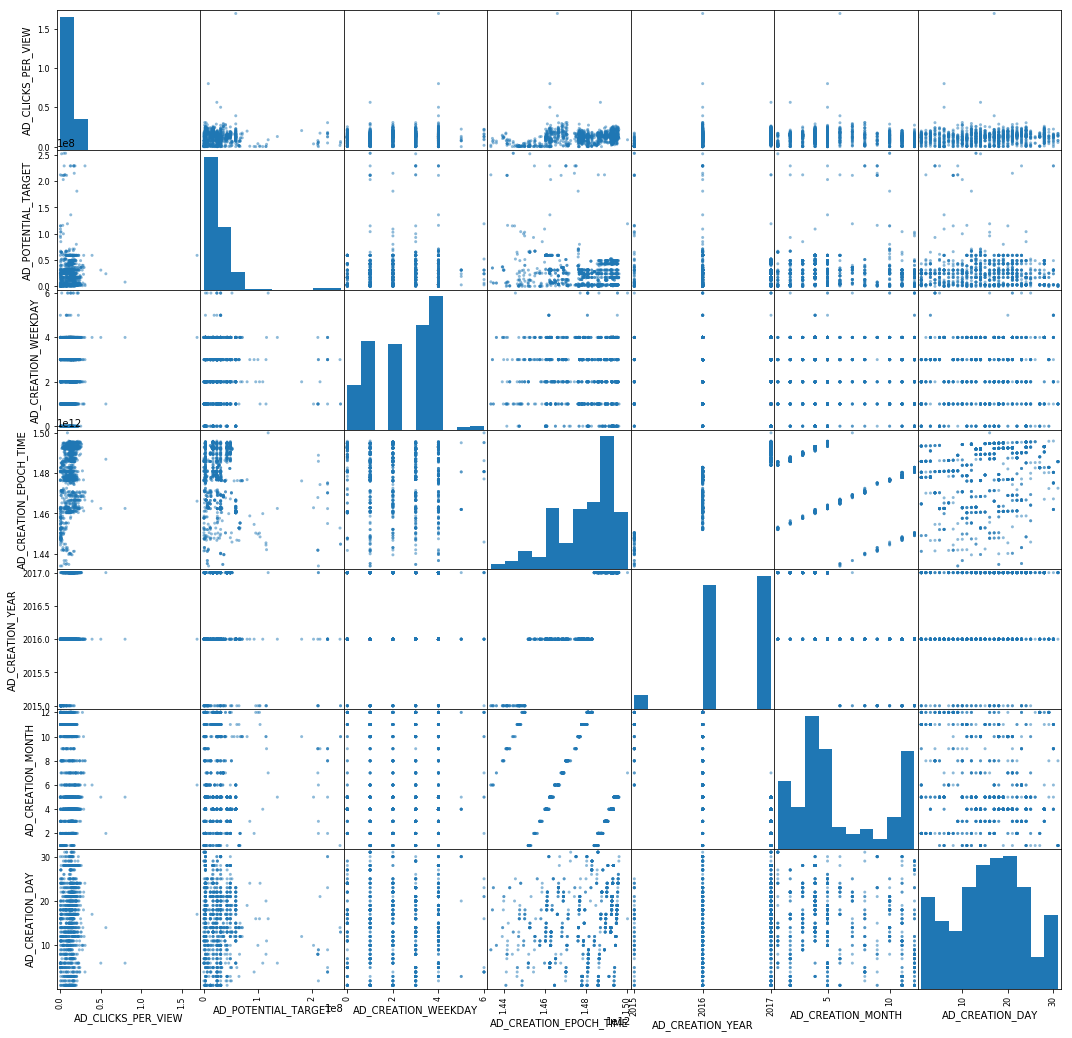

In [22]:
scatter_matrix(corrUniqueDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], figsize=(18, 18))
corrUniqueDf.corr()

In [23]:
corrDuplicateDf = duplicateDF[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']]
corrDuplicateDf = corrDuplicateDf.dropna()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET,AD_CREATION_WEEKDAY,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY
AD_CLICKS,1.000000,0.911341,0.138713,-0.089762,0.042847,-0.026788,-0.117634,0.170208,-0.024911
AD_IMPRESSIONS,0.911341,1.000000,0.041505,-0.107084,0.087016,0.012070,-0.097119,0.197551,-0.068484
AD_CLICKS_PER_VIEW,0.138713,0.041505,1.000000,0.043567,-0.109194,0.147167,0.027827,0.174034,0.178609
AD_POTENTIAL_TARGET,-0.089762,-0.107084,0.043567,1.000000,0.006317,-0.077964,-0.059212,-0.025003,0.126271
AD_CREATION_WEEKDAY,0.042847,0.087016,-0.109194,0.006317,1.000000,0.066260,0.152106,-0.158860,-0.149532
AD_CREATION_EPOCH_TIME,-0.026788,0.012070,0.147167,-0.077964,0.066260,1.000000,0.831260,0.092794,0.097456
AD_CREATION_YEAR,-0.117634,-0.097119,0.027827,-0.059212,0.152106,0.831260,1.000000,-0.475437,0.056519
AD_CREATION_MONTH,0.170208,0.197551,0.174034,-0.025003,-0.158860,0.092794,-0.475437,1.000000,-0.003751
AD_CREATION_DAY,-0.024911,-0.068484,0.178609,0.126271,-0.149532,0.097456,0.056519,-0.003751,1.000000


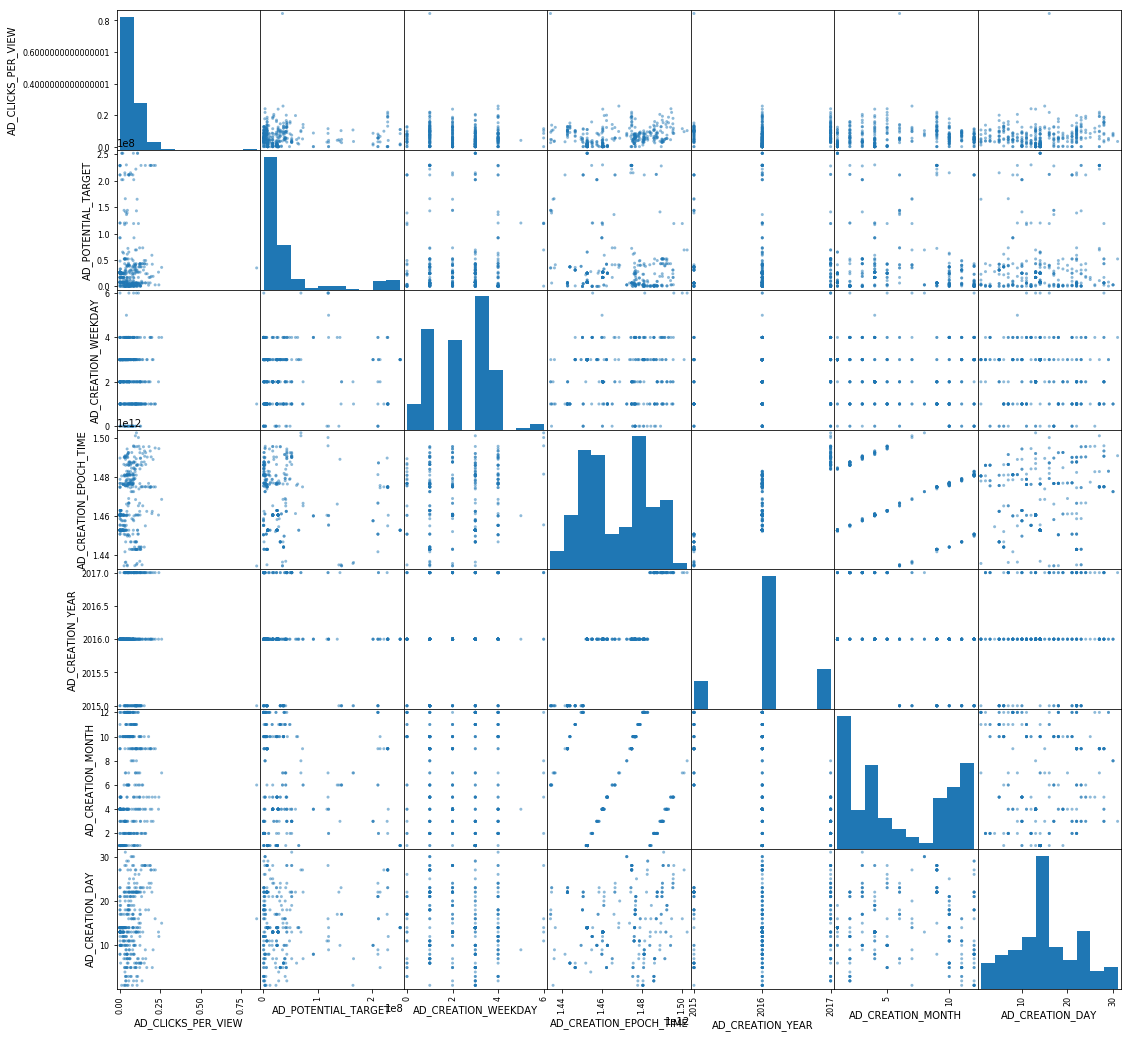

In [24]:
scatter_matrix(corrDuplicateDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], figsize=(18, 18))
corrDuplicateDf.corr()